In [39]:
import numpy as np
from numpy import mean
from numpy import absolute
from numpy import sqrt

import pandas as pd
import io

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from datetime import date

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor

import matplotlib.pyplot as plt

In [40]:
from google.colab import files
upload = files.upload()


Saving bmw_pricing_challenge.csv to bmw_pricing_challenge (1).csv


Reading the dataset and reviewing it

In [42]:
data = pd.read_csv(io.BytesIO(upload['bmw_pricing_challenge.csv']))
print(data)

     maker_key          model_key  mileage  engine_power registration_date  \
0          BMW                118   140411           100        2012-02-01   
1          BMW                 M4    13929           317        2016-04-01   
2          BMW                320   183297           120        2012-04-01   
3          BMW                420   128035           135        2014-07-01   
4          BMW                425    97097           160        2014-12-01   
...        ...                ...      ...           ...               ...   
4838       BMW    218 Gran Tourer    39743           110        2015-10-01   
4839       BMW  218 Active Tourer    49832           100        2015-06-01   
4840       BMW    218 Gran Tourer    19633           110        2015-10-01   
4841       BMW  218 Active Tourer    27920           110        2016-04-01   
4842       BMW                525   195840           160        2013-01-01   

        fuel paint_color     car_type  feature_1  feature_2  fe

Dropping maker key, as there is only one value in all rows.

In [43]:
data = data.drop('maker_key', axis=1)

Checking data attributes and null values. Then seeing the first 6 values of each column

In [44]:
print(data.dtypes)

print(data.isnull().sum())

data.head(6)
#There are 0 null values in the dataset. 

model_key            object
mileage               int64
engine_power          int64
registration_date    object
fuel                 object
paint_color          object
car_type             object
feature_1              bool
feature_2              bool
feature_3              bool
feature_4              bool
feature_5              bool
feature_6              bool
feature_7              bool
feature_8              bool
price                 int64
sold_at              object
dtype: object
model_key            0
mileage              0
engine_power         0
registration_date    0
fuel                 0
paint_color          0
car_type             0
feature_1            0
feature_2            0
feature_3            0
feature_4            0
feature_5            0
feature_6            0
feature_7            0
feature_8            0
price                0
sold_at              0
dtype: int64


,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01
5,335,152352,225,2011-05-01,petrol,black,convertible,True,True,False,False,True,True,True,True,17100,2018-02-01


Converting sold at and registration date columns to datetime to be able to create a new column called age. This column will determine the age of the vehicle in days

In [45]:
data['sold_at'] = pd.to_datetime(data['sold_at'])
data['registration_date'] = pd.to_datetime(data['registration_date'])
print(data.dtypes)

model_key                    object
mileage                       int64
engine_power                  int64
registration_date    datetime64[ns]
fuel                         object
paint_color                  object
car_type                     object
feature_1                      bool
feature_2                      bool
feature_3                      bool
feature_4                      bool
feature_5                      bool
feature_6                      bool
feature_7                      bool
feature_8                      bool
price                         int64
sold_at              datetime64[ns]
dtype: object


Creating a new column - "Age". 

In [46]:
data['age']=data['sold_at'] - data['registration_date']
data['age'].head()

0   2161 days
1    671 days
2   2132 days
3   1311 days
4   1217 days
Name: age, dtype: timedelta64[ns]

Converting boolean columns to 0 and 1, this way they can be included in the analysis.

In [47]:
data['feature_1'] = data['feature_1'].astype(int)
data['feature_2'] = data['feature_2'].astype(int)
data['feature_3'] = data['feature_3'].astype(int)
data['feature_4'] = data['feature_4'].astype(int)
data['feature_5'] = data['feature_5'].astype(int)
data['feature_6'] = data['feature_6'].astype(int)
data['feature_7'] = data['feature_7'].astype(int)
data['feature_8'] = data['feature_8'].astype(int)

data.dtypes

model_key                     object
mileage                        int64
engine_power                   int64
registration_date     datetime64[ns]
fuel                          object
paint_color                   object
car_type                      object
feature_1                      int64
feature_2                      int64
feature_3                      int64
feature_4                      int64
feature_5                      int64
feature_6                      int64
feature_7                      int64
feature_8                      int64
price                          int64
sold_at               datetime64[ns]
age                  timedelta64[ns]
dtype: object

Renaming columns to identify the property of each category.

In [48]:
data = data.rename(columns = {'feature_1': 'HasMoonRoof','feature_2': 'HasLeatherSeats','feature_3': 'HasHeatedSeats','feature_4': 'HasNavSystem','feature_5': 'HasBluetooth', 'feature_6':'HasRemoteStart', 'feature_7': 'HasBlindSpotMonitoring', 'feature_8': 'HasMSportPackage'})

Summarizing the data to identify incorrect values and outliers.

In [49]:
perc = [0.20, 0.40, 0.60, 0.80]
desc = data.describe(percentiles=perc)
desc

,mileage,engine_power,HasMoonRoof,HasLeatherSeats,HasHeatedSeats,HasNavSystem,HasBluetooth,HasRemoteStart,HasBlindSpotMonitoring,HasMSportPackage,price,age
count,4.843000e+03,4843.00000,4843.000000,4843.000000,4843.000000,4843.000000,4843.000000,4843.000000,4843.000000,4843.000000,4843.000000,4843
mean,1.409628e+05,128.98823,0.549659,0.792690,0.201941,0.198637,0.460458,0.241379,0.932067,0.540987,15828.081767,1983 days 17:23:21.197604800
std,6.019674e+04,38.99336,0.497579,0.405421,0.401490,0.399015,0.498485,0.427964,0.251657,0.498369,9220.285684,927 days 06:40:57.469456592
min,-6.400000e+01,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,215 days 00:00:00
20%,9.253780e+04,100.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,10100.000000,1430 days 00:00:00
40%,1.264246e+05,120.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,12900.000000,1673 days 00:00:00
50%,1.410800e+05,120.00000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,14200.000000,1765 days 00:00:00
60%,1.547736e+05,135.00000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,15500.000000,1887 days 00:00:00
80%,1.828160e+05,150.00000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,20200.000000,2222 days 00:00:00
max,1.000376e+06,423.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,178500.000000,10258 days 00:00:00


Visualizing Fuel Type


*   We can see that diesel is the most popular fuel type in available pre-owned BMW vehicles
*   Petrol is the second one on the list, however it is nowhere close to diesel



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

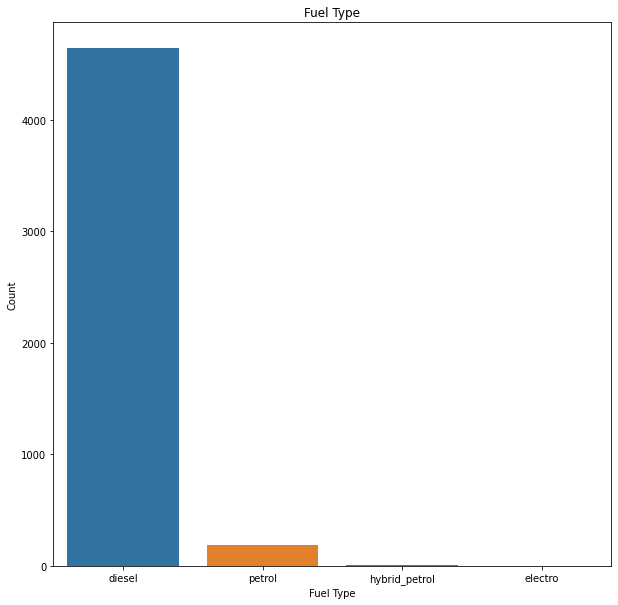

In [50]:
plt.figure(figsize=(10,10))
sns.countplot(data["fuel"])
plt.title("Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Count")
plt.show

Comparing fuel type with price, we see that hybrid petrol is the most expensive type of vehicle in this dataset.

Text(0, 0.5, 'Price')

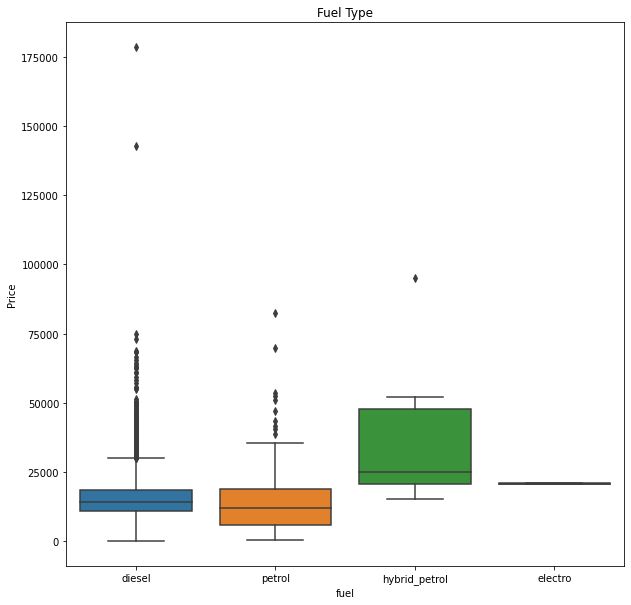

In [51]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data,x="fuel",y="price",order=data.fuel.value_counts().index);
plt.title("Fuel Type")
plt.ylabel("Price")

Replacing fuel types to numbers so that it can be included in the analysis.

In [52]:
data['fuel'] = data['fuel'].replace("diesel",1)
data['fuel'] = data['fuel'].replace("petrol",2)
data['fuel'] = data['fuel'].replace("hybrid_petrol",3)
data['fuel'] = data['fuel'].replace("electro",4)

Visualizing Car Type


*   Estate vehicles were the most popular car type
*   Number two on the list are sedans, followed by suv's.




/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

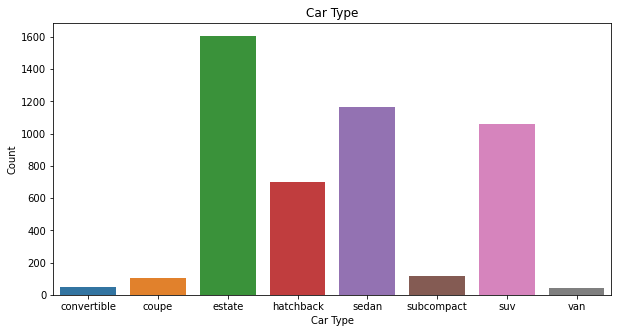

In [53]:
plt.figure(figsize=(10,5))
sns.countplot(data["car_type"])
plt.title("Car Type")
plt.xlabel("Car Type")
plt.ylabel("Count")
plt.show

Viewing car type against price:


*   SUV and coupe are the most expensive type of BMW



Text(0, 0.5, 'Price')

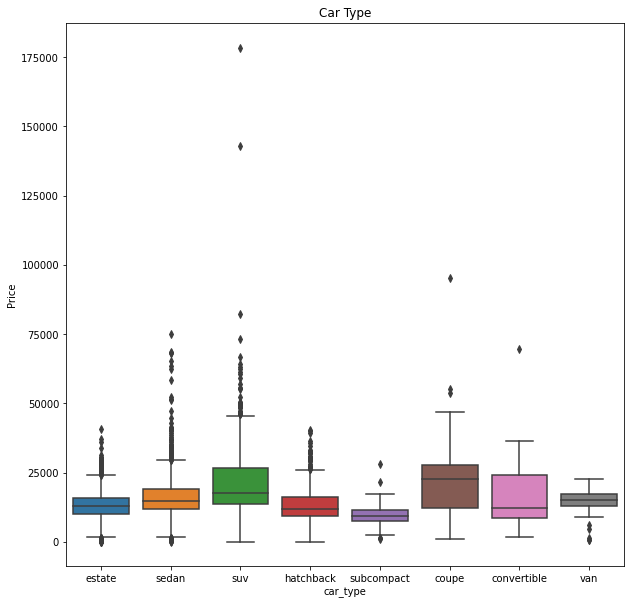

In [54]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data,x="car_type",y="price",order=data.car_type.value_counts().index);
plt.title("Car Type")
plt.ylabel("Price")

Replacing values with numbers to include in our analysis.

In [55]:
data['car_type'] = data['car_type'].replace("convertible",1)
data['car_type'] = data['car_type'].replace("coupe",2)
data['car_type'] = data['car_type'].replace("estate",3)
data['car_type'] = data['car_type'].replace("hatchback",4)
data['car_type'] = data['car_type'].replace("sedan",5)
data['car_type'] = data['car_type'].replace("subcompact",6)
data['car_type'] = data['car_type'].replace("suv",7)
data['car_type'] = data['car_type'].replace("van",8)

Visualizing Paint Color


*   The most popular color among pre-owned BMW vehicles is black, followed by grey.



/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<function matplotlib.pyplot.show>

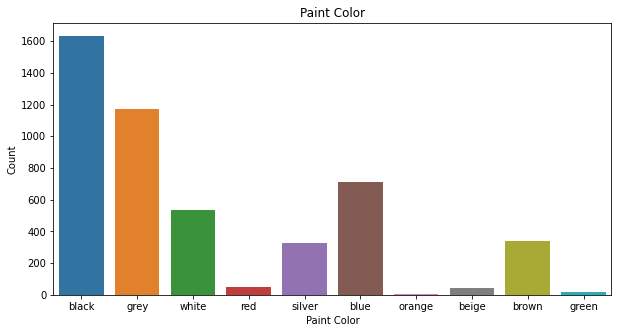

In [56]:
plt.figure(figsize=(10,5))
sns.countplot(data["paint_color"])
plt.title("Paint Color")
plt.xlabel("Paint Color")
plt.ylabel("Count")
plt.show

Visualizing if paint color affects price.


*   The color orange is the most expensive in this dataset on an average
*   The most expensive seems to be an outlier, and is the color blue.



Text(0, 0.5, 'Price')

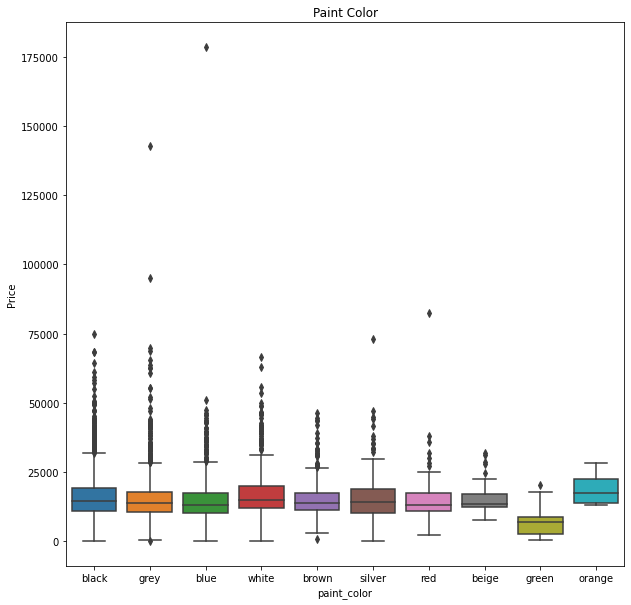

In [57]:
plt.figure(figsize=(10,10))
sns.boxplot(data=data,x="paint_color",y="price",order=data.paint_color.value_counts().index);
plt.title("Paint Color")
plt.ylabel("Price")

Replacing colors to numbers in order to include them in the analysis.

In [58]:
data['paint_color'] = data['paint_color'].replace("black",1)
data['paint_color'] = data['paint_color'].replace("grey",2)
data['paint_color'] = data['paint_color'].replace("white",3)
data['paint_color'] = data['paint_color'].replace("red",4)
data['paint_color'] = data['paint_color'].replace("silver",5)
data['paint_color'] = data['paint_color'].replace("blue",6)
data['paint_color'] = data['paint_color'].replace("orange",7)
data['paint_color'] = data['paint_color'].replace("beige",8)
data['paint_color'] = data['paint_color'].replace("brown",9)
data['paint_color'] = data['paint_color'].replace("green",10)

Viewing histograms for each attribute.

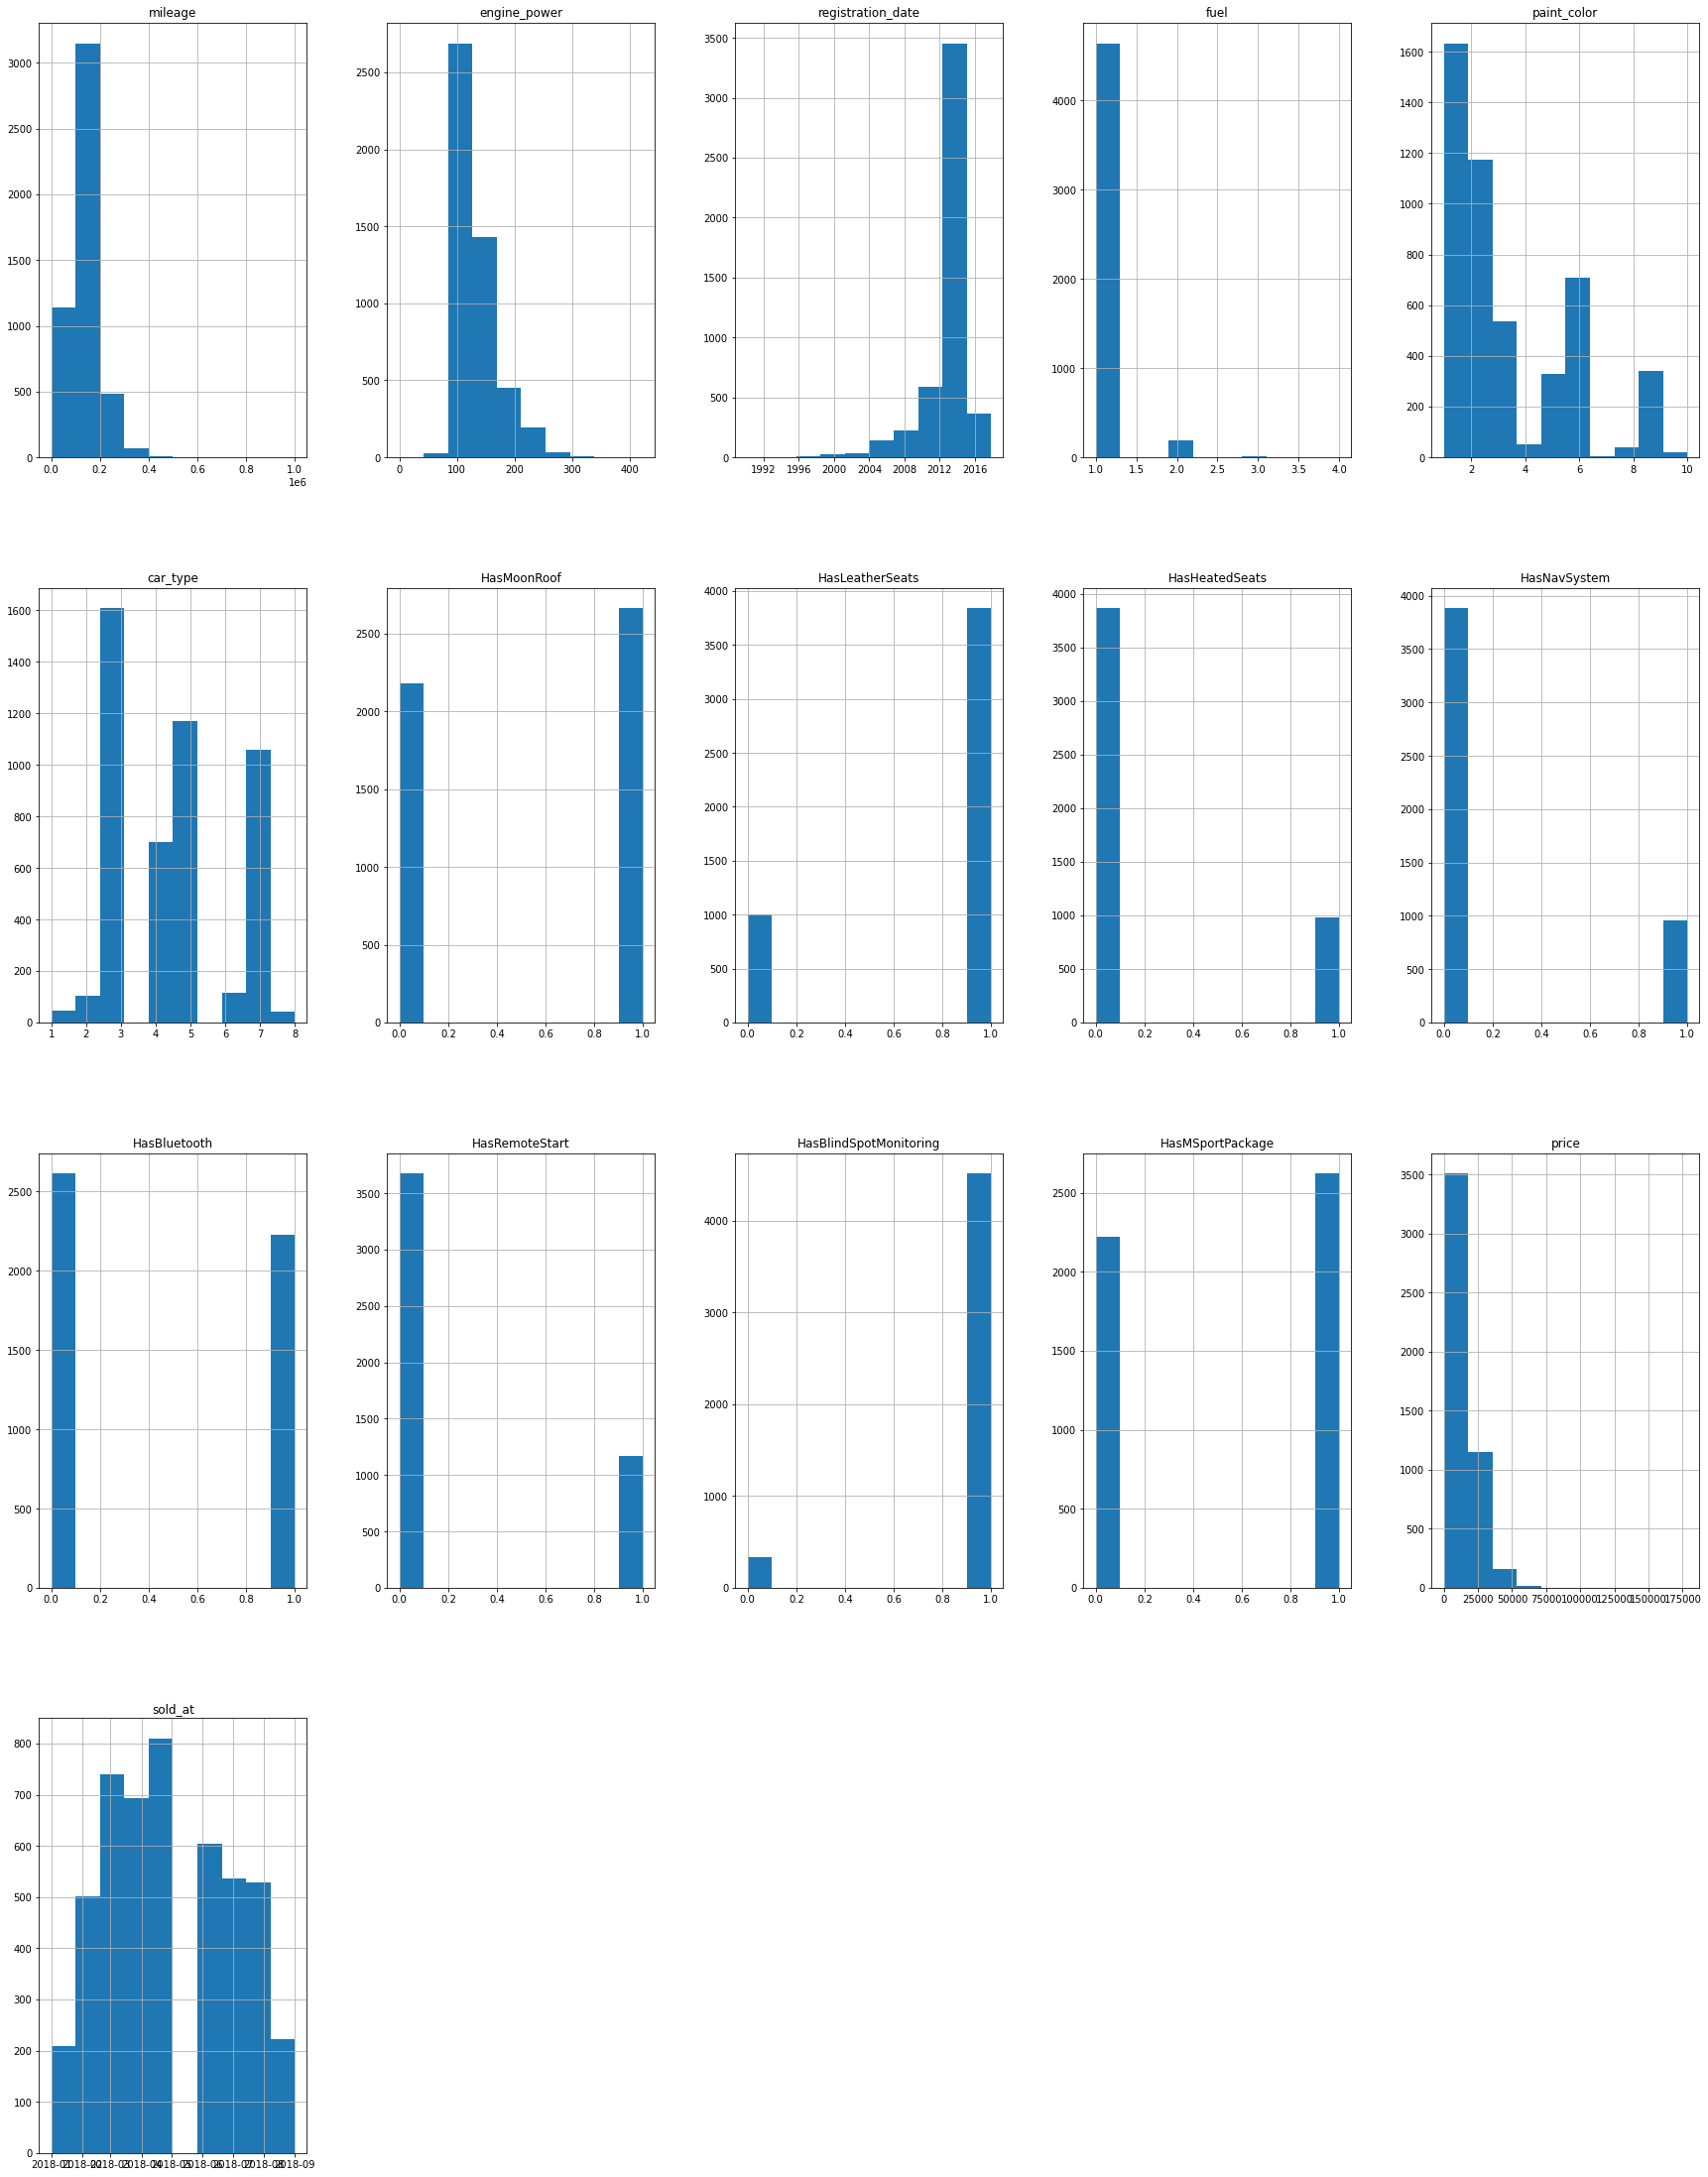

In [38]:
hist = data.hist(layout=(5,5), figsize=(30,50))

Adjusting incorrect and illogical values.

*   Mileage had -64 as a value, that is not possible. This will be ammended to reflect 64.
*   Engine power had a value of 0, once again this is not possible. This will be adjusted according to the mean

In [59]:
data['mileage'].replace(
    to_replace=[-64],
    value=64,
    inplace=True
)

In [60]:
data['mileage'].min()

64

The value that replaced the 0 for engine power was the mean of the column engine power.

In [61]:
data['engine_power'].replace(
    to_replace=[0],
    value=128.98233,
    inplace=True
)

In [62]:
data['engine_power'].min()

25.0

Corr plot to view the correlation between price and other variables.

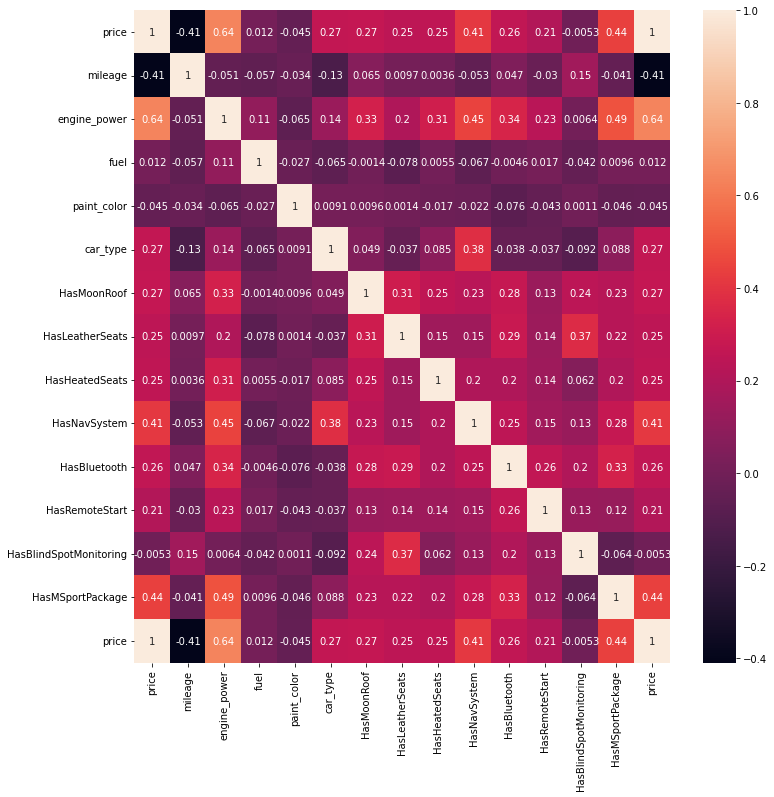

In [63]:
correlation1=plt.figure(figsize=(12,12))
corr=pd.concat([data['price'],data], axis=1).corr()
sns.heatmap(corr, annot=True)

Price is highly correlated with engine power. This is followed by Has M Sport Package and Has Nav System, among others.

Looking at engine power in closer detail.


*   100-150HP has the highest frequency 
*   Followed by 75-100HP



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fdd245f8290>]],
      dtype=object)

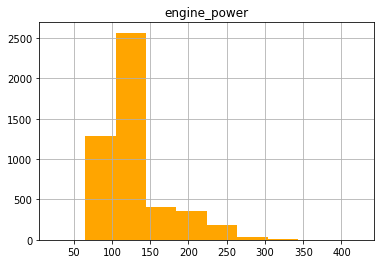

In [64]:
data.hist(column='engine_power', color='orange')

This boxplot of price allows us to visualize the varying prices in this dataset. We see that the minimum price is 0 and the maximum is 178500. Furthermore, we see that there are a great number of outliers, but this is understandable as there are a lot of features that go into determining the price of a vehicle. The average price in this dataset is $15828.

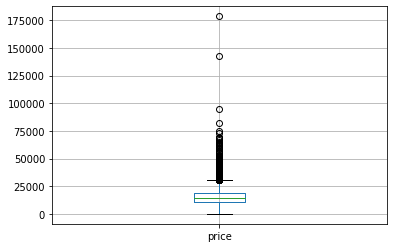

In [65]:
data.boxplot(column=["price"])

This scatterplot allows us to visualize the correlation between price and engine power. There is strong positive correlation, with a number of outliers which was expected.

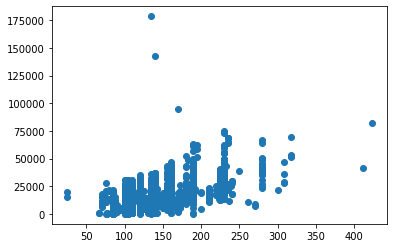

In [66]:
plt.scatter(data["engine_power"],data["price"])
plt.show()

Normalizing the numeric attributes according to the dataset. This process standardizes all the attributes selected. Features often have different ranges. Normalization ensures that the attributes that have larger scales will no longer affect other attributes with values of smaller scales.

In [67]:
cols_to_norm = ['price','mileage','paint_color','car_type','fuel','engine_power', 'HasMoonRoof', 'HasLeatherSeats', 'HasHeatedSeats', 'HasNavSystem', 'HasBluetooth', 'HasRemoteStart', 'HasBlindSpotMonitoring','HasMSportPackage']
data[cols_to_norm]=StandardScaler().fit_transform(data[cols_to_norm])

In [68]:
data.head()

,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,HasMoonRoof,HasLeatherSeats,HasHeatedSeats,HasNavSystem,HasBluetooth,HasRemoteStart,HasBlindSpotMonitoring,HasMSportPackage,price,sold_at,age
0,118,-0.009168,-0.745017,2012-02-01,-0.200198,-0.875628,-2.209949,0.905157,0.511397,-0.503031,-0.49787,1.082474,1.772811,0.269971,-1.085628,-0.491151,2018-01-01,2161 days
1,M4,-2.110531,4.826909,2016-04-01,4.288501,-0.471216,-2.209949,0.905157,0.511397,-0.503031,-0.49787,-0.923810,1.772811,0.269971,0.921126,5.843364,2018-02-01,671 days
2,320,0.703337,-0.231475,2012-04-01,-0.200198,-0.066804,-2.209949,-1.104781,-1.955430,-0.503031,-0.49787,1.082474,-0.564076,0.269971,-1.085628,-0.610465,2018-02-01,2132 days
3,420,-0.214782,0.153681,2014-07-01,-0.200198,0.337609,-2.209949,0.905157,0.511397,-0.503031,-0.49787,1.082474,1.772811,0.269971,0.921126,1.005704,2018-02-01,1311 days
4,425,-0.728784,0.795608,2014-12-01,-0.200198,0.742021,-2.209949,0.905157,0.511397,-0.503031,-0.49787,-0.923810,1.772811,0.269971,0.921126,1.905986,2018-04-01,1217 days


Dropping price from the dataframe to isolate it for prediction.

In [69]:
x = data[cols_to_norm].drop('price', axis=1)
y = data.price

Dividing the dataset to training and test sets. Random state was included to ensure results are reproducible.

In [70]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=42)

In [71]:
print(f"No. of x training examples: {x_train.shape[0]}")
print(f"No. of y training examples: {y_train.shape[0]}")
print(f"No. of x testing examples: {x_test.shape[0]}")
print(f"No. of y testing examples: {y_test.shape[0]}")

No. of x training examples: 968
No. of y training examples: 968
No. of x testing examples: 3875
No. of y testing examples: 3875


Model #1: Multiple Linear Regression

In [72]:
LR = LinearRegression()
LR.fit(x_train, y_train)

y_prediction = LR.predict(x_test)
y_prediction

array([ 0.14811824, -0.67523351,  1.10930452, ..., -0.67257656,
        0.02010355, -0.01705081])

In [73]:
print('Intercept: \n', LR.intercept_)
print('Coefficients: \n', LR.coef_)

Intercept: 
 0.01777155673560478
Coefficients: 
 [-0.38299976 -0.02469446  0.0914665  -0.0355812   0.50995183  0.0491526
  0.08185497  0.04989617  0.09284903 -0.04117361  0.03563168  0.02690171
  0.14397569]


In [74]:
print("R Square Value :",LR.score(x_test,y_test))

R Square Value : 0.5844520221195526


Predicting the price of a car that has a mileage of 500, 1400 HP, uses petrol as fuel, is silver, is a sedan, has a moon roof, has leather seats, has bluetooth, has blind spot monitoring and is 7300 days old. The price is $827.73

In [75]:
Predictedprice = LR.predict([[500, 1400, 2, 5,5,1,1,0,0,1,0,1,7300]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


In [76]:
print(Predictedprice)

[827.6396755]


Model 1b. Random Forest Regression.


*   Determining the tree count and random data count
*   Evaluation Algorithm: The closer it is to 1, the better the model is. In this case it is 0.6.



In [77]:
RFRegressor= RandomForestRegressor(n_estimators=50, random_state = 42) 
RFRegressor.fit(x_train,y_train) # create model

data_score =[]
# Calculate R Square
print("R Square Value :",RFRegressor.score(x_test,y_test))
data_score.append(RFRegressor.score(x_test,y_test))

R Square Value : 0.6447192423894189


Model 1c. Decision Tree Regressor

This model has a very low R square value, and will be rejected.

In [78]:
DecisionTreeReg = DecisionTreeRegressor()
DecisionTreeReg.fit(x_train,y_train)
predict_DecisionTreeReg = DecisionTreeReg.predict(x_test)
print("R Square Value :", DecisionTreeReg.score(x_test,y_test))
data_score.append(DecisionTreeReg.score(x_test,y_test))

R Square Value : 0.4437596433190789


Model #2: K Fold Cross Validation

Defining the predictor and response variables

In [79]:
a = data [['price','mileage','fuel', 'paint_color', 'car_type','engine_power', 'HasMoonRoof', 'HasLeatherSeats', 'HasHeatedSeats', 'HasNavSystem', 'HasBluetooth', 'HasRemoteStart', 'HasBlindSpotMonitoring','HasMSportPackage']]
b = data ['price']

Defining cross-validation method being used and building multiple linear regression model. At the end, using k-fold cross validation to evaluate model and viewing the mean absolute error

The mean absolute error (MAE) is ~6.87e-16. This is the average absolute error between my model prediction and the actual observed data. We know that the lower the MAE, the more closely a model is able to predict the actual observations. In this case, the MAE is very miniscule.

In [80]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
model = LinearRegression()
scores = cross_val_score(model, a, b, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
mean(absolute(scores))

6.872111166299963e-16